# Eric's Thesis Project

In [134]:
import pandas as pd
import numpy as np
import sys, os
import pickle, sqlite3
import datetime
import math, random
from scipy import stats
import scipy

import findata_utils as fd

import matplotlib.pyplot as plt
from matplotlib import rcParams

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
def event_timespan(d):
    if d<0:
        return 'pre-event'
    elif d>0:
        return 'post-event'
    else:
        return 'event'
    return 'err'

# Connect to databases
db = 'C:\\Datasets\\thesis.db'
conn = sqlite3.connect(db)
c = conn.cursor()

hdf_path = 'C:\\Datasets\\thesis.h5'
hdf = pd.HDFStore(hdf_path)

colors = {}
colors['pre-event'] = 'xkcd:dark salmon'
colors['post-event'] = 'xkcd:denim'

time_range = [-90,90]

# Load datasets
## Get French 3-Factor Data

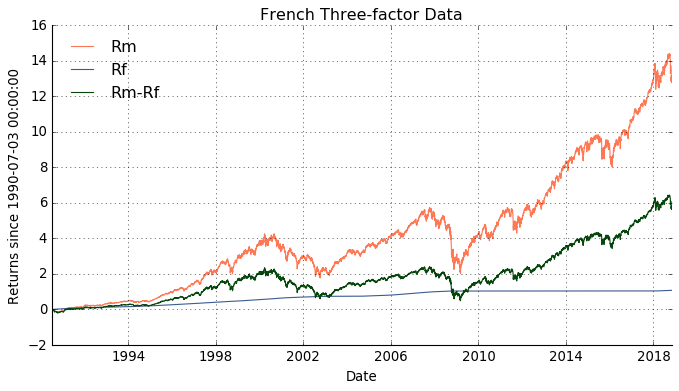

In [4]:
threefactor = fd.get_french('North_America_3_Factors_Daily')
for column in threefactor.columns[1:]:
    threefactor[column] = threefactor[column]*0.01
threefactor['Rm'] = threefactor['Mkt-RF']+threefactor['RF']
threefactor['date'] = threefactor['Date'].apply(lambda Date: datetime.datetime.strptime(str(Date),'%Y%m%d'))
threefactor['culm_Rm'] = (threefactor['Rm']+1).cumprod()

# Visualize French data to sanity check
plt.style.use('classic')

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

plt.title('French Three-factor Data')
plt.xlabel('Date')
plt.ylabel('Returns since {Start}'.format(Start=threefactor['date'].min()))
plt.plot(threefactor['date'],((threefactor['Rm']+1).cumprod()-1),color='xkcd:melon')
plt.plot(threefactor['date'],((threefactor['RF']+1).cumprod()-1),color='xkcd:denim blue')
plt.plot(threefactor['date'],((threefactor['Mkt-RF']+1).cumprod()-1), color='xkcd:forest green')
plt.legend(['Rm','Rf','Rm-Rf'], frameon=False, loc='best')
plt.show()

## Pull price data from my local SQLite instance

In [5]:
# Query the database for close price data
px = pd.read_sql('''
    SELECT date,ticker, MAX(c) AS px
    FROM cfmrc
    WHERE ticker IN
        (SELECT ticker FROM indexchanges) 
    GROUP BY ticker,date'''
    ,conn).drop_duplicates()

# Query the database for close price data
allpx = pd.read_sql('''
    SELECT date,ticker, MAX(c) AS px
    FROM cfmrc
    GROUP BY ticker,date'''
    ,conn).drop_duplicates()

print('Obtained %d close prices' % len(px.index))

rebal_day = pd.read_sql('''
    SELECT s.date AS rebal_date, s.ticker, c AS rebal_px, flag
    FROM cfmrc s
    INNER JOIN indexchanges i
    WHERE s.date=i.date 
        AND s.ticker=i.ticker'''
    ,conn)

print('Obtained rebalance day price info for %d securities' % len(rebal_day.index))

Obtained 277212 close prices
Obtained rebalance day price info for 178 securities


### Exclude stocks which were added, then removed again (or vice-versa)

In [6]:
multiple_samples = rebal_day.groupby(by='ticker')['flag'].count().reset_index()
multiple_samples = multiple_samples[multiple_samples.flag>1].ticker.unique()

rebal_day = rebal_day[~rebal_day.ticker.isin(multiple_samples)]
if len(multiple_samples)>0:
    print('Removed {Count} securities which were both added and removed: {Tickers}'.format(Count=len(multiple_samples),
                                                                                      Tickers=', '.join(multiple_samples)))
else:
    print('Removed no duplicated samples')

Removed 26 securities which were both added and removed: ACQ, AKG, AR, AVO, BDI, BXE, CF, CLC, CXR, FRC, FVI, GUY, HNL, IAE, KDX, NAL, NVA, P, PLI, POU, PSG, PSN, RIO, SGY, TCW, WJX


## Calculate returns and factors on securities
 * __px__: closing price on a given day
 * __rebalpx__: closing price on the day of the change
 * __return__: total return since/til addition (deletion)
 * __rebal__: date of the rebalance
 * __date__: today's date
 * __flag__: addition (deletion)
 * __d__: days until (since) addition/deletion

In [7]:
# Merge rebalance data to price data
df = px.merge(rebal_day, on=['ticker'])

# Parse dates
df['date'] = df['date'].apply(lambda date: datetime.datetime.strptime(date,'%Y-%m-%d'))
df['rebal_date'] = df['rebal_date'].apply(lambda date: datetime.datetime.strptime(date,'%Y-%m-%d'))

# Days unitl rebal
df['d'] = (df['date']-df['rebal_date']).apply(lambda d: d.days)
df.sort_values(by=['ticker','d'], inplace=True)

# Get directional change
df['flag'] = df['flag'].apply(lambda flag: 1 if flag==1 else -1)

# Compute price deltas
df['delta_px'] = (df['px']-df['rebal_px'])*df['flag']

# And use this to compute the culmulative daily return, indexed to the rebal day
df['return_to_rebal'] = df['delta_px']/df['rebal_px']

# Also, use this to determine daily returns per security
df['daily_return'] =(df['px'].diff()/df['px'])
for ticker in df['ticker'].unique():
    # Correct the first day return for each security
    df.ix[(df['ticker']==ticker) & (df['date']==df[df['ticker']==ticker]['date'].min()), 'daily_return']=0

df = df.merge(threefactor[['Rm','culm_Rm','date']], on=['date'])

# Find the culmulative market return per rebalance day
adjustments = df[df['d']==0][['ticker','culm_Rm']]
adjustments.columns = ['ticker','culm_Rm_t0']
df = df.merge(adjustments, on=['ticker'])
df['market_return_to_rebal'] = df['culm_Rm']-df['culm_Rm_t0']

# Use this to calculate the alpha
# TODO: risk-adjust
df['alpha_to_rebal'] = df['return_to_rebal']-df['market_return_to_rebal']
df['timespan'] = df['d'].apply(lambda d: event_timespan(d))

print(df.head())
hdf.put(key='daily', value=df, format='t', append=False)

        date  ticker    px rebal_date  rebal_px  flag    d  delta_px  \
0 2012-09-19  AAR.UN  4.97 2015-03-20      5.01     1 -912     -0.04   
1 2012-09-20  AAR.UN  5.00 2015-03-20      5.01     1 -911     -0.01   
2 2012-09-21  AAR.UN  4.96 2015-03-20      5.01     1 -910     -0.05   
3 2012-09-24  AAR.UN  5.00 2015-03-20      5.01     1 -907     -0.01   
4 2012-09-25  AAR.UN  4.99 2015-03-20      5.01     1 -906     -0.02   

   return_to_rebal  daily_return      Rm   culm_Rm  culm_Rm_t0  \
0        -0.007984      0.000000  0.0016  7.142968   10.638146   
1        -0.001996      0.006000 -0.0016  7.131539   10.638146   
2        -0.009980     -0.008065  0.0003  7.133679   10.638146   
3        -0.001996      0.008000 -0.0034  7.109424   10.638146   
4        -0.003992     -0.002004 -0.0109  7.031932   10.638146   

   market_return_to_rebal  alpha_to_rebal   timespan  
0               -3.495178        3.487194  pre-event  
1               -3.506607        3.504611  pre-event  
2    

In [128]:
length_of_ranking_period = 13

df['return_ranking_to_rebal']=(df['rebal_px']-df['ranking_px'])/df['rebal_px']

df['rebal_last_eom'] = df['rebal_date'].apply(lambda rebal_date: (rebal_date-pd.Timedelta(days=30)) +pd.tseries.offsets.MonthEnd(1) )
df['rebal_ranking_end'] = df['rebal_last_eom']
df['rebal_ranking_start'] = df['rebal_ranking_end']-pd.Timedelta(days=length_of_ranking_period)

avg_days = df[['ticker','rebal_date','rebal_ranking_end','rebal_ranking_start']].drop_duplicates()
avg_days['ranking_end_to_rebal'] = avg_days['rebal_date']-avg_days['rebal_ranking_end']
avg_days = avg_days.groupby(by=['ranking_end_to_rebal']).agg({'ticker':'count'}).reset_index()
avg_days = np.sum(avg_days['ranking_end_to_rebal']*avg_days['ticker'])/np.sum(avg_days['ticker'])
avg_days = avg_days.astype('timedelta64[D]').astype(int)

## Deal with financing flows
Seperate rebalance from financing trades. Other securities must be sold IOT buy the adds. Reweighting and share adjustments (buy-backs). Isolate for these.

# Explore the Data
## Determine whether abnormal returns (or reversion) exist

Reversion: T+1 astonishing (i.e., wrong way on rebalance day close)... also consider T+5 vs Bechmark. Right-way reversion on Monday; possibly due to the 3-day break over the weekend.

Risk/return on inclusions. Is it an arb opprotunity? Or is there risk associated with e.g. shortage of liquidity? Understand whether short sales affect it (look at short interest for securities being included -- TMX Short Position Report)?

     d market_return_to_rebal           alpha_to_rebal            \
                         mean       std           mean       std   
0 -365              -1.017542  0.871511       0.086834  1.562951   
1 -364              -1.020135  0.881799       0.084857  1.583422   
2 -361              -1.017532  0.887970       0.088484  1.567697   
3 -360              -0.917926  0.853297      -0.040145  1.627506   
4 -359              -0.923129  0.865919      -0.050693  1.681655   

  return_to_rebal            
             mean       std  
0       -0.930708  1.133947  
1       -0.935278  1.143522  
2       -0.929049  1.125689  
3       -0.958071  1.194128  
4       -0.973822  1.239454  


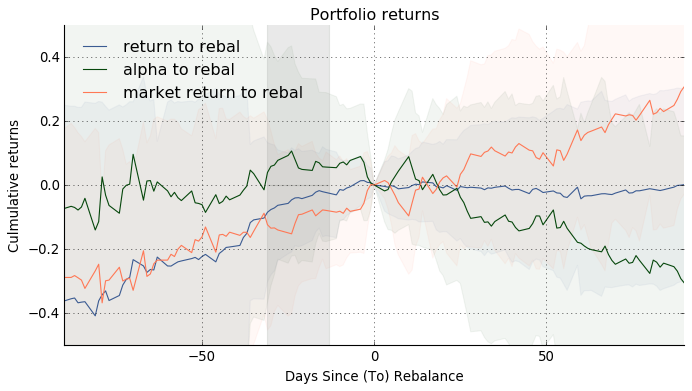

In [146]:
aggregated = df[df['d'].between(-365, 365, inclusive=True) & df['flag'].isin([-1,1])].groupby(by='d').agg({
                                 'market_return_to_rebal':['mean','std'],
                                 'alpha_to_rebal':['mean','std'],
                                 'return_to_rebal':['mean','std']}).reset_index()
print(aggregated.head())

# Plot it

plt.style.use('classic')

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

lines = {'return_to_rebal':'xkcd:denim blue',
         'alpha_to_rebal':'xkcd:forest green',
        'market_return_to_rebal':'xkcd:melon'}

for line in lines:
    ax.plot(aggregated['d'],aggregated[line]['mean'], color=lines[line])
    ax.fill_between(aggregated['d'], aggregated[line]['mean']-aggregated[line]['std'], aggregated[line]['mean']+aggregated[line]['std'], color=lines[line], alpha=0.05)

# Plot the ranking period
ax.fill_between([-(length_of_ranking_period+avg_days),-length_of_ranking_period], [1,1], color='xkcd:grey', alpha=0.2)
ax.fill_between([-(length_of_ranking_period+avg_days),-length_of_ranking_period], [-1,-1], color='xkcd:grey', alpha=0.2)

ax.legend([line.replace('_',' ') for line in lines.keys()], frameon=False, loc='best')

plt.title('Portfolio returns')
plt.ylabel('Culmulative returns')
plt.xlabel('Days Since (To) Rebalance')

xlim = [-365,365]
#ylim = [aggregated[aggregated['d'].between(xlim[0], xlim[1], inclusive=True)][list(lines.keys())].min().min(),
#        aggregated[aggregated['d'].between(xlim[0], xlim[1], inclusive=True)][list(lines.keys())].max().max()]

plt.xlim(time_range)
plt.ylim(-0.5,0.5)
plt.show()

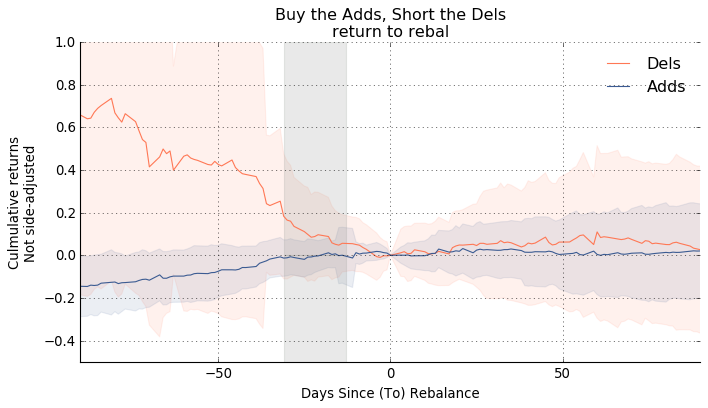

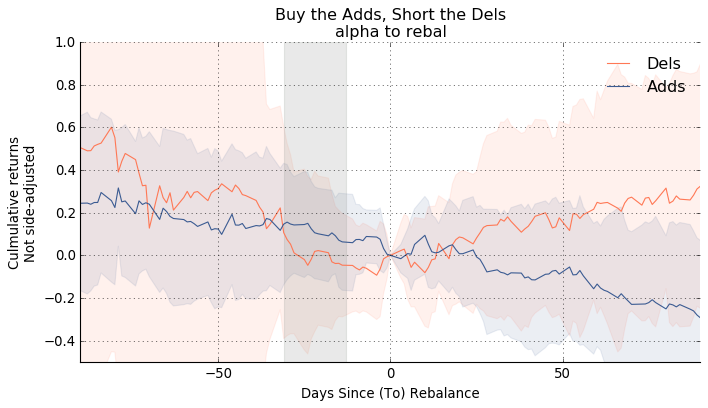

In [148]:
for factor in ['return_to_rebal','alpha_to_rebal']:

    by_side = df[df['d'].between(-365, 365, inclusive=True)].groupby(by=['d','flag']).agg({
                                     factor:['mean','std']}).reset_index()
    # Plot it
    plt.style.use('classic')

    fig = plt.figure(figsize=(10,5))
    fig.patch.set_facecolor('white')

    ax = fig.add_subplot(1, 1, 1)

    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.grid(True,axis='both',linestyle=':')

    sides = {'Dels':-1,'Adds':1}
    colors = {'Dels':'xkcd:melon','Adds':'xkcd:denim blue'}
    for side in sides.keys():

        ax.plot(by_side[by_side['flag']==sides[side]]['d'],
                by_side[by_side['flag']==sides[side]][factor]['mean']*sides[side],
                color=colors[side])

        ax.fill_between(by_side[by_side['flag']==sides[side]]['d'],
                        (by_side[by_side['flag']==sides[side]][factor]['mean']-by_side[by_side['flag']==sides[side]][factor]['std'])*sides[side],
                        (by_side[by_side['flag']==sides[side]][factor]['mean']+by_side[by_side['flag']==sides[side]][factor]['std'])*sides[side],
                        color=colors[side], alpha=0.1)

    ax.legend(sides.keys(), frameon=False, loc='best')
    
    # Plot the ranking period
    ax.fill_between([-(length_of_ranking_period+avg_days),-length_of_ranking_period], [1,1], color='xkcd:grey', alpha=0.2)
    ax.fill_between([-(length_of_ranking_period+avg_days),-length_of_ranking_period], [-1,-1], color='xkcd:grey', alpha=0.2)

    plt.title('Buy the Adds, Short the Dels\n{Factor}'.format(Factor=factor.replace('_',' ')))
    plt.ylabel('Culmulative returns\nNot side-adjusted')
    plt.xlabel('Days Since (To) Rebalance')

    plt.xlim(time_range)
    plt.ylim(-0.5,1)
    plt.show()
    #plt.ylim(ylim)

### Hypothetical strategy: short the adds (buy the dels) and hedge with the market on t+1

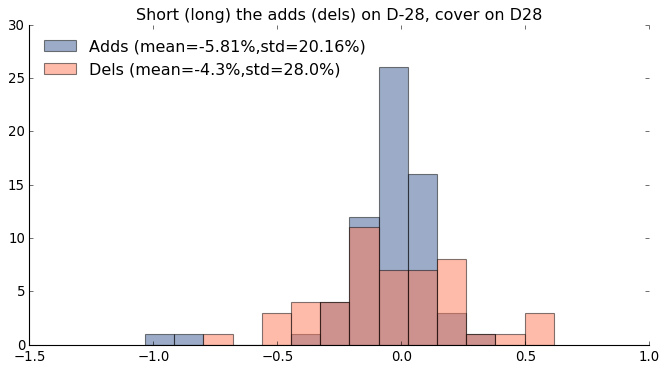

In [229]:
plt.style.use('classic')

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
    
t0 = df[df['d']==time_range[0]][['ticker','rebal_date','flag','px']]
t1 = df[df['d']==time_range[1]][['ticker','px']]
delta = pd.merge(left=t0,right=t1, on=['ticker'], suffixes=['0','1'])
delta['dpx'] = delta['px1']-delta['px0']
delta['return'] = -delta['dpx']/delta['px0']*delta['flag']

bins = np.linspace(delta['return'].min(), delta['return'].max(),15)

flag_colors = {-1:'xkcd:melon',1:'xkcd:denim blue'}
side_names = {-1:'Dels',1:'Adds'}

legend = []
for flag in delta['flag'].unique():
    plt.hist(delta[delta['flag']==flag]['return'], color=flag_colors[flag], alpha=0.5, bins=bins)
    legend.append('{flag} (mean={mean}%,std={std}%)'.format(flag=side_names[flag],
                                                            mean=round(delta[delta['flag']==flag]['return'].mean()*100,2),
                                                            std=round(delta[delta['flag']==flag]['return'].std()*100,2)))
plt.legend(legend, frameon=False, loc='best')
    
plt.title('Short (long) the adds (dels) on D{t0}, cover on D{t1}'.format(t0=time_range[0],
    t1=time_range[1]))
plt.show()

### Is there a bifurcation in the deletes?

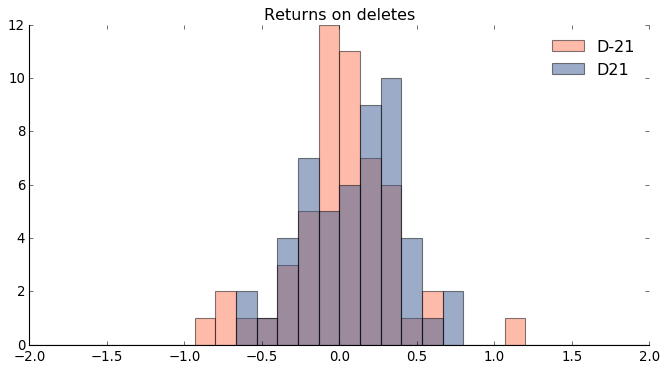

In [237]:
plt.style.use('classic')

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)

bins = np.linspace(-2,2,31)
plt.hist(df[(df['flag']==-1) & (df['d']==time_range[0]   )]['alpha_to_rebal']*-1, color=flag_colors[-1], alpha=0.5, bins=bins)
plt.hist(df[(df['flag']==-1) & (df['d']==time_range[1])]['alpha_to_rebal']*-1, color=flag_colors[1], alpha=0.5, bins=bins)
plt.title('Returns on deletes')

# TODO: look at TSX60 adds/dels

plt.legend(['D{Days}'.format(Days=time_range[0])
            ,'D{Days}'.format(Days=time_range[1])], 
            frameon=False, loc='best')
plt.show()

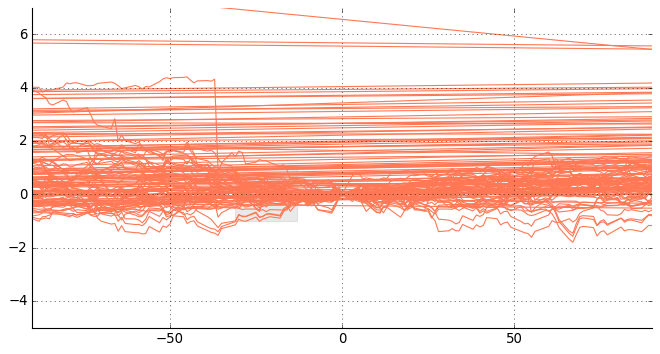

In [151]:
plt.style.use('classic')

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

del_tickers = df[df['flag']==-1]['ticker'].unique()
for ticker in del_tickers:
    plt.plot(df[df['ticker']==ticker]['d'], df[df['ticker']==ticker]['alpha_to_rebal']*-1, color='xkcd:melon', alpha=1)
#plt.legend(del_tickers, frameon=False, loc='best')

# Plot the ranking period
ax.fill_between([-(length_of_ranking_period+avg_days),-length_of_ranking_period], [1,1], color='xkcd:grey', alpha=0.2)
ax.fill_between([-(length_of_ranking_period+avg_days),-length_of_ranking_period], [-1,-1], color='xkcd:grey', alpha=0.2)

plt.xlim(time_range)
plt.ylim(-5,7)
plt.show()

## Calculate risk factors, per-security

In [267]:
beta = df[['date','d','ticker','daily_return','Rm']].drop_duplicates()

risk = []
for ticker in beta['ticker'].unique():
    # Calculate the risk per security
    sample = beta[beta['ticker']==ticker][['d','daily_return','Rm']]
    
    for timespan in ['lifetime','pre-event','post-event']:
        # Compute for whether or not this is before or after the rebalance event
        security_risk = pd.Series(name=ticker)
        security_risk['timespan'] = timespan
        
        if timespan=='pre-event':
            subsample=sample[sample['d']<0]
        elif timespan=='post-event':
            subsample=sample[sample['d']>0]
        else:
            subsample=sample

        slope, intercept, r_value, p_value, std_err = stats.linregress(subsample['Rm'], subsample['daily_return'])

        security_risk['intercept'] = intercept
        security_risk['beta'] = slope
        security_risk['idio'] = r_value**2

        risk.append(pd.DataFrame(security_risk).T.reset_index())
    
risk = pd.concat(risk)
risk['beta'] = risk['beta'].astype(float)
risk['idio'] = risk['idio'].astype(float)
risk['intercept'] = risk['intercept'].astype(float)

risk = risk.merge(df[['ticker','flag']].drop_duplicates(), left_on='index', right_on='ticker', how='outer')

print(risk.head(5))
hdf.put(key='risk', value=risk, format='t', append=False)

    index    timespan  intercept      beta      idio  ticker  flag
0  AAR.UN    lifetime   0.000103  0.344620  0.055522  AAR.UN     1
1  AAR.UN   pre-event  -0.000291  0.372295  0.059813  AAR.UN     1
2  AAR.UN  post-event   0.000405  0.328364  0.053134  AAR.UN     1
3    AC.B    lifetime        NaN       NaN       NaN    AC.B     1
4    AC.B   pre-event   0.000130  0.711204  0.062714    AC.B     1


### Visualize changes in risk factors

ValueError: Inputs must not be empty.

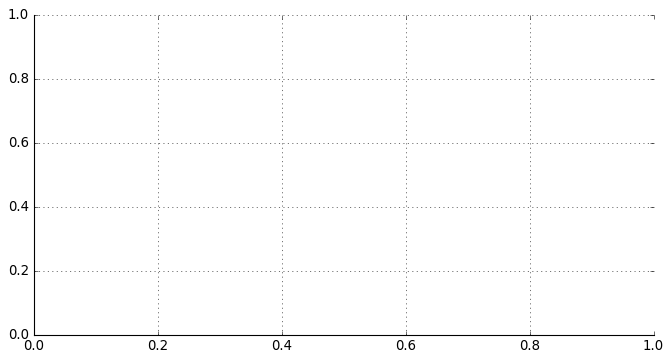

In [211]:
risk_pivot = pd.pivot_table(risk, columns=['flag','timespan'], index=['ticker'], values=['beta']).reset_index()

plt.style.use('classic')

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

factor = 'beta'
x,y = 'pre-event', 'post-event'

legend = []

X = np.linspace(-0.5, 2)

for side in [-1,1]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(risk_pivot.dropna()[factor][side][x], 
                                                                   risk_pivot.dropna()[factor][side][y])
    
    ax.scatter(risk_pivot[factor][side][x], risk_pivot[factor][side][y], color=flag_colors[side])
    ax.plot(X, intercept+(slope*X))
    legend.append(side_names[side])
    legend.append('{Side} (fit)'.format(Side=side_names[side]))

ax.legend(legend, frameon=False, loc='best')

plt.title('Pre/post-rebalance {Factor}'.format(Factor=factor))
plt.ylabel(y)
plt.xlabel(x)

plt.show()

# Explore comparables and time-series
## What happens to securities which are added and then deleted, or vice versa?

0   2015-03-20
1   2015-03-20
2   2015-03-20
3   2015-03-20
4   2015-03-20
5   2015-03-20
6   2015-03-20
7   2015-03-20
8   2015-03-20
9   2015-03-20
Name: rebal_date, dtype: datetime64[ns]
0   2015-02-28
1   2015-02-28
2   2015-02-28
3   2015-02-28
4   2015-02-28
5   2015-02-28
6   2015-02-28
7   2015-02-28
8   2015-02-28
9   2015-02-28
Name: rebal_date, dtype: datetime64[ns]


## What happens during the ranking week?

In [152]:
avg_ranking_price = df.loc[df['date'].between(df['rebal_ranking_start'],
                                              df['rebal_ranking_end'])].groupby(by='ticker').agg({'px':'sum'})/10

avg_ranking_price.columns=['ranking_px']

try:
    df.drop(avg_ranking_price.columns, inplace=True)
except:
    pass

df = df.merge(avg_ranking_price, on=['ticker'], how='left')

In [153]:
df

,date,ticker,px,rebal_date,rebal_px,flag,d,delta_px,return_to_rebal,daily_return,...,alpha_to_rebal,timespan,rebal_last_eom,rebal_ranking_end,rebal_ranking_start,ranking_px_x,ranking_px_y,ranking_px_x,return_ranking_to_rebal,ranking_px_y
0,2012-09-19,AAR.UN,4.97,2015-03-20,5.01,1,-912,-0.04,-0.007984,0.000000,...,3.487194,pre-event,2015-02-28,2015-02-28,2015-02-15,4.526,4.526,4.526,0.096607,4.526
1,2012-09-20,AAR.UN,5.00,2015-03-20,5.01,1,-911,-0.01,-0.001996,0.006000,...,3.504611,pre-event,2015-02-28,2015-02-28,2015-02-15,4.526,4.526,4.526,0.096607,4.526
2,2012-09-21,AAR.UN,4.96,2015-03-20,5.01,1,-910,-0.05,-0.009980,-0.008065,...,3.494488,pre-event,2015-02-28,2015-02-28,2015-02-15,4.526,4.526,4.526,0.096607,4.526
3,2012-09-24,AAR.UN,5.00,2015-03-20,5.01,1,-907,-0.01,-0.001996,0.008000,...,3.526726,pre-event,2015-02-28,2015-02-28,2015-02-15,4.526,4.526,4.526,0.096607,4.526
4,2012-09-25,AAR.UN,4.99,2015-03-20,5.01,1,-906,-0.02,-0.003992,-0.002004,...,3.602223,pre-event,2015-02-28,2015-02-28,2015-02-15,4.526,4.526,4.526,0.096607,4.526
5,2012-09-26,AAR.UN,4.92,2015-03-20,5.01,1,-905,-0.09,-0.017964,-0.014228,...,3.628333,pre-event,2015-02-28,2015-02-28,2015-02-15,4.526,4.526,4.526,0.096607,4.526
6,2012-09-27,AAR.UN,4.96,2015-03-20,5.01,1,-904,-0.05,-0.009980,0.008065,...,3.562902,pre-event,2015-02-28,2015-02-28,2015-02-15,4.526,4.526,4.526,0.096607,4.526
7,2012-09-28,AAR.UN,4.95,2015-03-20,5.01,1,-903,-0.06,-0.011976,-0.002020,...,3.591287,pre-event,2015-02-28,2015-02-28,2015-02-15,4.526,4.526,4.526,0.096607,4.526
8,2012-10-01,AAR.UN,4.97,2015-03-20,5.01,1,-900,-0.04,-0.007984,0.004024,...,3.574878,pre-event,2015-02-28,2015-02-28,2015-02-15,4.526,4.526,4.526,0.096607,4.526
9,2012-10-02,AAR.UN,4.99,2015-03-20,5.01,1,-899,-0.02,-0.003992,0.004008,...,3.573226,pre-event,2015-02-28,2015-02-28,2015-02-15,4.526,4.526,4.526,0.096607,4.526


## What happens when securities diverge from their market/sector/industry group?

If returns on a security are decoupled from industry returns, is this a predictor of index changes? Regress excess returns vs the index... 5 minute bins and daily

# Isolation of Extraneous Factoe

## Cluster by ADV and side?

## How does volatility affect extent or timing of trade pre-positioning?

High vol => trade is compressed. Low vol => trade is spread out (lower cost?) What happens over march break? Typically, wrong-way trades.

## Did volatility during rebalances after the TSX introduced LOC orders to the MOC facility?

In Apr 2015, TSX made changes to the MOC facility to include LOC orders. Vol probably went down. So, segment out June 2015 onwards.

## Did reversion decrease when S&P changed the benchmark to the 5-day VWAP?

## Is there an increase in liquidity risk commensurate with abnormal returns?

Does it create additional risk? Does it create additional returns? Factors that drive each of those.

In [74]:
hdf.close()
conn.close()